<a href="https://colab.research.google.com/github/cynthianekesa/waste-segregation_model/blob/main/SUMMATIVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AIM OF THE PROJECT**

This assignment aims to explore the implementation of Machine Learning Models with regularization, optimization, and Error analysis techniques used in machine learning to improve models' performance, convergence speed, and efficiency.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d techsash/waste-classification-data

Dataset URL: https://www.kaggle.com/datasets/techsash/waste-classification-data
License(s): CC-BY-SA-4.0
 99% 424M/427M [00:05<00:00, 122MB/s]
100% 427M/427M [00:05<00:00, 81.4MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/waste-classification-data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
#Importing the necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3

I have a dataset with 25.1k images, split into a train directory containing 22,564 images and a test directory with 2,513 images. Since the full dataset is large and training on all the images would be time-consuming, I’ve decided to use only the images in the test directory to train my model, rather than using the entire dataset or the images in the train directory.

In [ ]:
# Define the path to the test dataset
test_dir = "/content/DATASET/TEST"

In [ ]:
# Load the dataset from the 'test' directory
evaluation_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=True,  # Shuffle the images
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Getting class names for test dataset
evaluation_classes = evaluation_dataset.class_names
print(f"Classes in test set: {evaluation_classes}")

Found 2513 files belonging to 2 classes.
Classes in test set: ['O', 'R']


In [ ]:
evaluation_dataset.cardinality().numpy()

79

In [ ]:
# Taking a single batch of images and labels (batch size = 32, image size = 224x224)
for batch in evaluation_dataset.take(1):
    images, labels = batch
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch: {labels.numpy()}")


Image batch shape: (32, 224, 224, 3)
Label batch: [1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1]


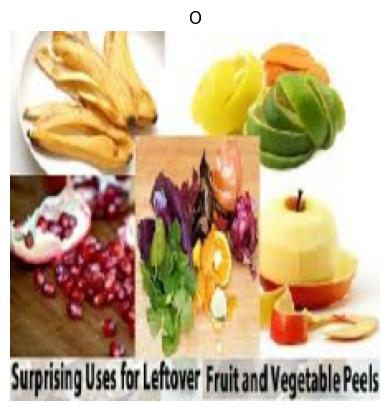

In [ ]:
#Viewing one of the images
for images, labels in evaluation_dataset.take(1):
  plt.imshow(images[0].numpy().astype("uint8"))
  plt.title(evaluation_classes[labels[0]])
  plt.axis("off")

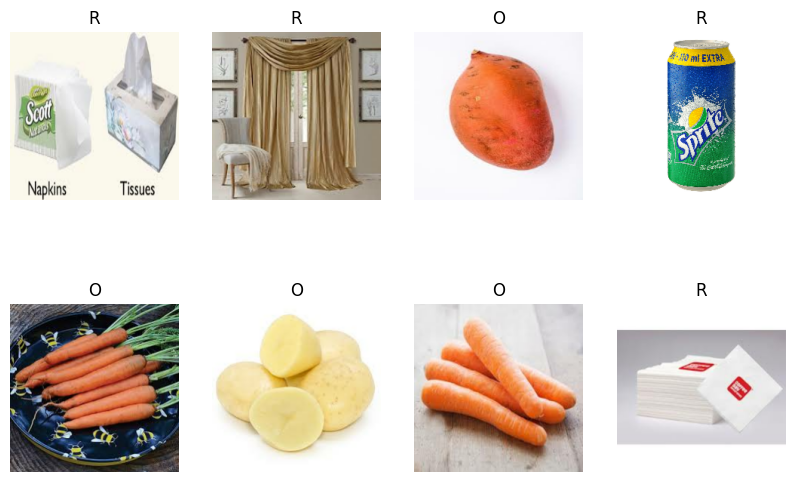

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure size
plt.figure(figsize=(10, 10))

# Take one batch of images and labels from the test dataset
images, labels = next(iter(evaluation_dataset))

# Plot the first 12 images and their corresponding labels
for idx in range(8):
    ax = plt.subplot(3, 4, idx + 1)
    plt.imshow(images[idx].numpy().astype("uint8"))  # Convert image to uint8 for display
    plt.title(evaluation_classes[labels[idx]])  # Set the title to the class name
    plt.axis("off")  # Hide axis

# Show the plot
plt.show()


In [ ]:
import tensorflow as tf

def splitting_dataset_tf(evaluation_ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_buffer=10000):
    # Calculate the total size of the dataset
    evaluation_ds_size = evaluation_ds.cardinality().numpy()

    # Shuffle the dataset if required
    if shuffle:
        evaluation_ds = evaluation_ds.shuffle(shuffle_buffer, seed=12)

    # Calculate sizes for each split
    train_size = int(train_split * evaluation_ds_size)
    val_size = int(val_split * evaluation_ds_size)

    # Split the dataset
    train_eds = evaluation_ds.take(train_size)
    val_eds = evaluation_ds.skip(train_size).take(val_size)
    test_eds = evaluation_ds.skip(train_size + val_size)

    return train_eds, val_eds, test_eds

datasets = splitting_dataset_tf(evaluation_dataset)
train_eds, val_eds, test_eds = datasets


In [ ]:
len(train_eds), len(val_eds), len(test_eds)

(63, 7, 9)

In [ ]:
def prepare_dataset(dataset):
    return dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_eds = prepare_dataset(train_eds)
val_eds = prepare_dataset(val_eds)
test_eds = prepare_dataset(test_eds)


In [ ]:
def create_scaling_layer(image_size):
    return tf.keras.Sequential([
        layers.Resizing(image_size, image_size),
        layers.Rescaling(1.0 / 255)
    ])

scaling = create_scaling_layer(IMAGE_SIZE)

In [ ]:
def create_image_augmentation_layer():
    return tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images both horizontally and vertically
        layers.RandomRotation(0.2)                      # Randomly rotate images by up to 20%
    ])

image_augmentation = create_image_augmentation_layer()


In [ ]:
#Training the Vanilla Model
vanilla_model = models.Sequential([
    scaling,
    image_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

vanilla_model.build(input_shape=input)

vanilla_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 224, 224, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 224, 224, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (32, 222, 222, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (32, 111, 111, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (32, 109, 109, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (32, 54, 54, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (32, 52, 52, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (32, 26, 26, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (32, 24, 24, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (32, 12, 12, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (32, 9216)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (32, 64)                    │         589,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (32, 2)                     │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,266 (2.61 MB)

 Trainable params: 683,266 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vanilla_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history = vanilla_model.fit(
    train_eds,
    epochs = 20,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_eds
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.6479 - loss: 0.6991 - val_accuracy: 0.8839 - val_loss: 0.2902
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8543 - loss: 0.3668 - val_accuracy: 0.8973 - val_loss: 0.2938
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8964 - loss: 0.2886 - val_accuracy: 0.9062 - val_loss: 0.2678
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8936 - loss: 0.2702 - val_accuracy: 0.9375 - val_loss: 0.1964
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9053 - loss: 0.2349 - val_accuracy: 0.9152 - val_loss: 0.2126
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9105 - loss: 0.2217 - val_accuracy: 0.9062 - val_loss: 0.2057
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9120 - loss: 0.2252 - val_accuracy: 0.9330 - val_loss: 0.1649
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9169 - loss: 0.2442 - val_accuracy: 0.9286 - v

In [ ]:
test_result = vanilla_model.evaluate(test_eds)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9284 - loss: 0.1735


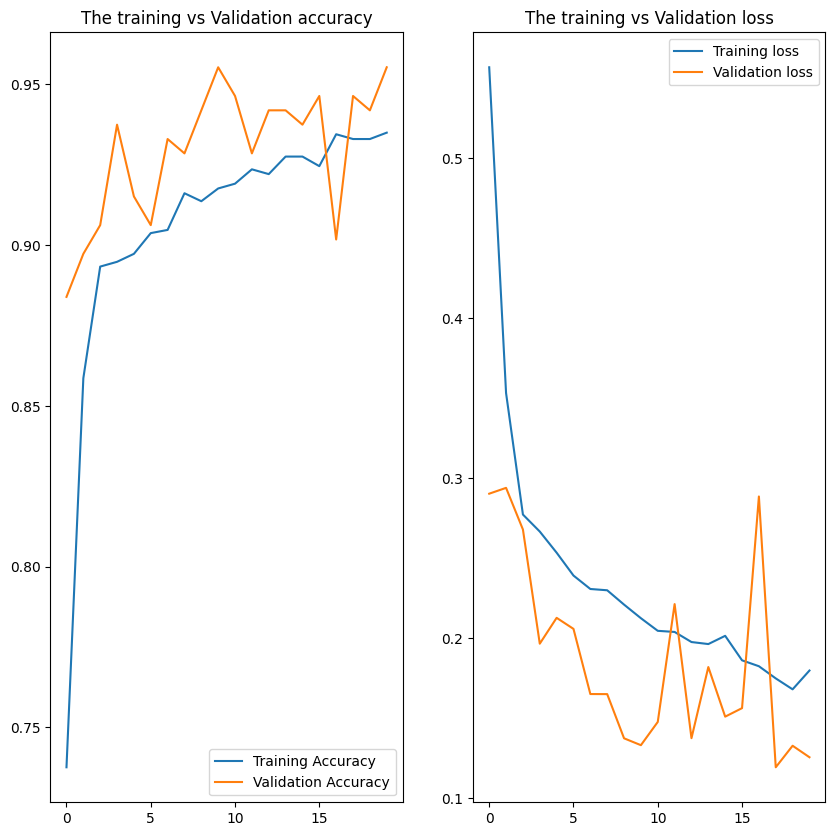

In [ ]:
#Doing a plot to visualize the output

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(range(20), accuracy, label='Training Accuracy')
plt.plot(range(20), val_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('The training vs Validation accuracy');

plt.subplot(1, 2, 2)
plt.plot(range(20), loss, label='Training loss')
plt.plot(range(20), val_loss, label='Validation loss')
plt.legend()
plt.title('The training vs Validation loss');

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


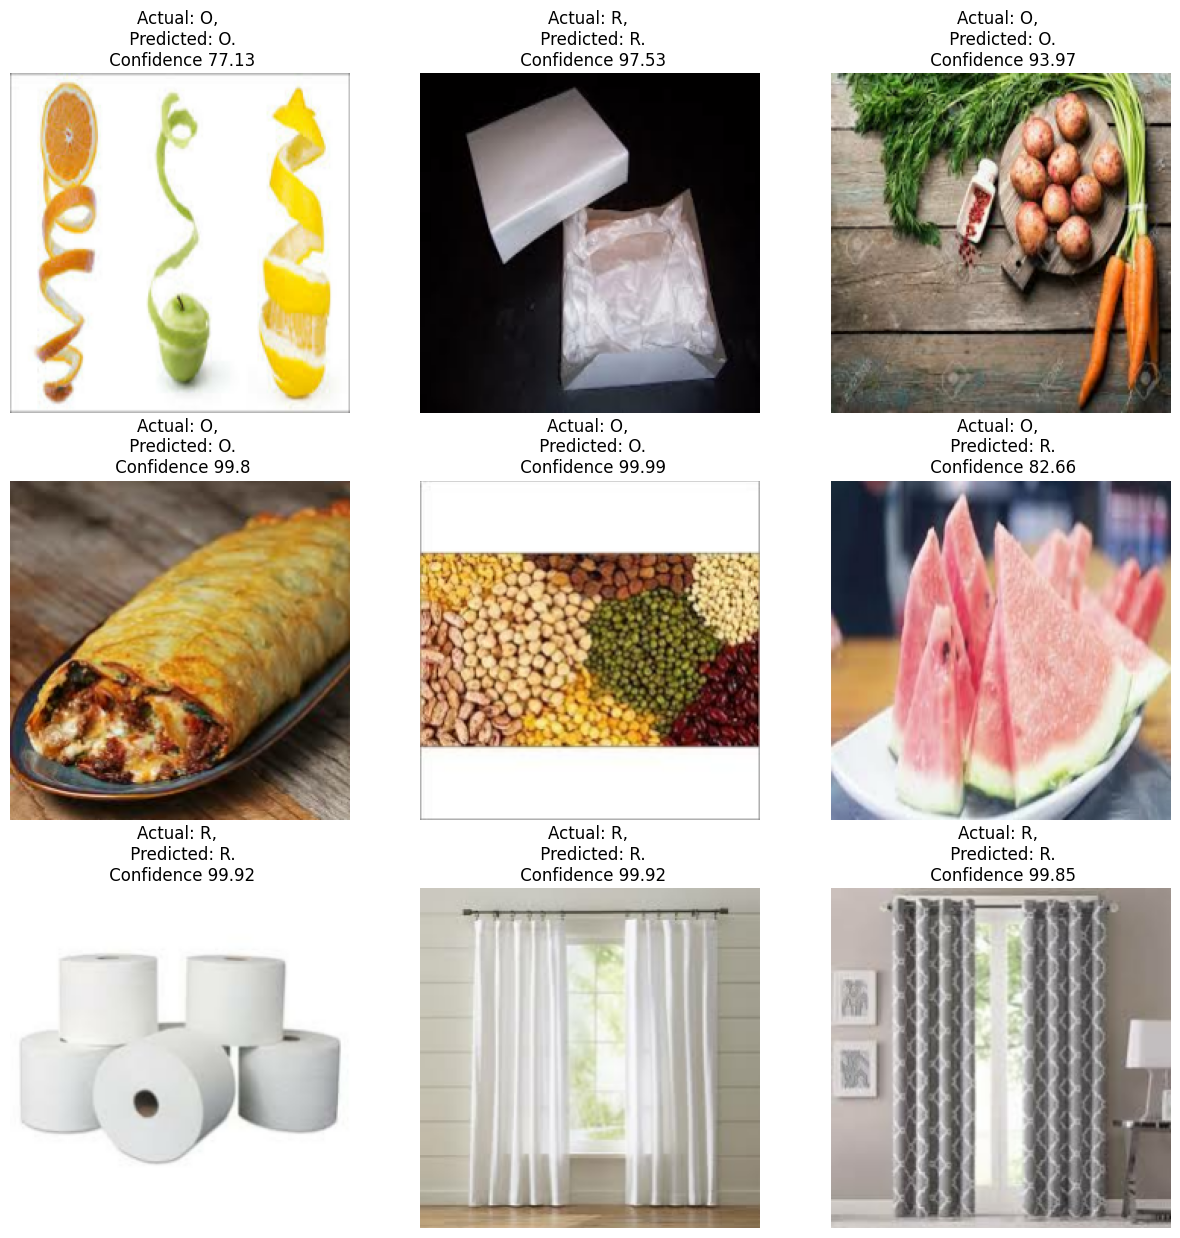

In [ ]:
#Doing some predictions
import numpy as np

def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = vanilla_model.predict(img_array)

  predicted_class = evaluation_classes[np.argmax(predictions[0])]
  confidence_level = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence_level

plt.figure(figsize=(15,15))
for images, labels in test_eds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence_level = predict(vanilla_model, images[i].numpy())
    actual_class = evaluation_classes[labels[i]]

    plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence {confidence_level}')
    plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Confusion Matrix:
 [[122   4]
 [ 12 150]]

Classification Report:
                 precision    recall  f1-score   support

   O (Organic)       0.91      0.97      0.94       126
R (Recyclable)       0.97      0.93      0.95       162

      accuracy                           0.94       288
     macro avg       0.94      0.95      0.94       288
  weighted avg       0.95      0.94      0.94       288


Model Performance Metrics:
Accuracy: 0.9444
Precision: 0.9740
Recall: 0.9259
F1 Score: 0.9494


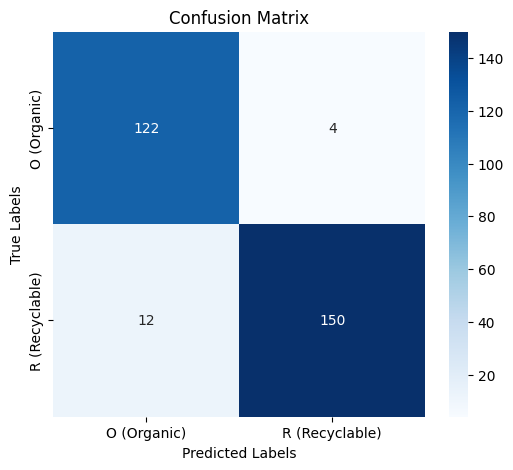

In [ ]:
# Error Analysis visualization tailored for binary classification (O: Organic, R: Recyclable)
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Step 1: Get true labels and predictions from the test set
y_true = []
y_pred = []

# Iterate over the test set to collect predictions and true labels
for images, labels in test_eds:
    preds = vanilla_model.predict(images)  # Get predictions from your model
    y_true.extend(labels.numpy())  # True labels: directly use the labels, assuming they're already class indices
    y_pred.extend(np.argmax(preds, axis=1))  # Predicted labels: get predicted class indices from softmax outputs

# Convert lists to numpy arrays for compatibility with metrics
y_true = np.array(y_true).astype(int)  # Ensure y_true is integer type
y_pred = np.array(y_pred)

# Step 2: Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Define the target names for the classes
target_names = ['O (Organic)', 'R (Recyclable)']

# Step 3: Generate a classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=target_names))

# Step 4: Calculate additional metrics: Accuracy, Precision, Recall, F1 Score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

# Print the calculated metrics
print(f"\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 5: Visualize the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
# Saving the model using Pickle
import pickle

with open('vanilla_model.pkl', 'wb') as f:
    pickle.dump(vanilla_model, f)

**Training the model with the Optimization technique**

In [ ]:
#Training the Model with optimization technique
model = models.Sequential([
    scaling,
    image_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), kernel_regularizer=l2(0.001)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.build(input_shape=input)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 224, 224, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 224, 224, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (32, 222, 222, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_60 (MaxPooling2D)      │ (32, 111, 111, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (32, 109, 109, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_61 (MaxPooling2D)      │ (32, 54, 54, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (32, 52, 52, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_62 (MaxPooling2D)      │ (32, 26, 26, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (32, 24, 24, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_63 (MaxPooling2D)      │ (32, 12, 12, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (32, 9216)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (32, 64)                    │         589,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (32, 2)                     │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,266 (2.61 MB)

 Trainable params: 683,266 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history1 = model.fit(
    train_eds,
    epochs=20,
    batch_size=32,
    validation_data=val_eds,
    callbacks=[early_stopping]
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9185 - loss: 0.2477 - val_accuracy: 0.9464 - val_loss: 0.1686
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9264 - loss: 0.2065 - val_accuracy: 0.9420 - val_loss: 0.2011
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9300 - loss: 0.1945 - val_accuracy: 0.9509 - val_loss: 0.1581
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9204 - loss: 0.2334 - val_accuracy: 0.9464 - val_loss: 0.1630
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9293 - loss: 0.2007 - val_accuracy: 0.9375 - val_loss: 0.1737
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9238 - loss: 0.2092 - val_accuracy: 0.9554 - val_loss: 0.1494
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9301 - loss: 0.1931 - val_accuracy: 0.9464 - val_loss: 0.1504
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9234 - loss: 0.2005 - val_accuracy: 0.9196 - v

In [ ]:
test_result = model.evaluate(test_eds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9617 - loss: 0.1032


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

Confusion Matrix:
 [[122   4]
 [ 10 152]]

Classification Report:
                 precision    recall  f1-score   support

   O (Organic)       0.92      0.97      0.95       126
R (Recyclable)       0.97      0.94      0.96       162

      accuracy                           0.95       288
     macro avg       0.95      0.95      0.95       288
  weighted avg       0.95      0.95      0.95       288


Model Performance Metrics:
Accuracy: 0.9514
Precision: 0.9744
Recall: 0.9383
F1 Score: 0.9560


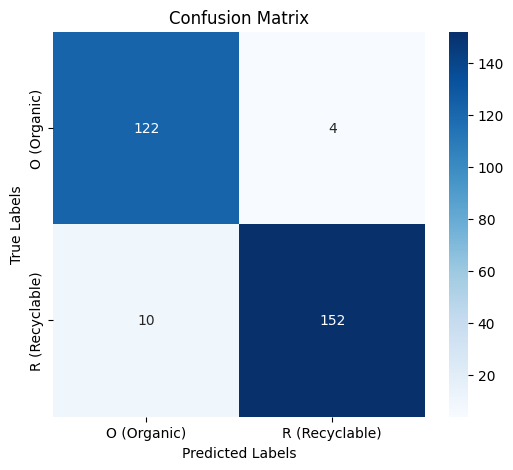

In [ ]:
#Get true labels and predictions from the test set
y_true = []
y_pred = []

# Iterate over the test set to collect predictions and true labels
for images, labels in test_eds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Convert lists to numpy arrays for compatibility with metrics
y_true = np.array(y_true).astype(int)
y_pred = np.array(y_pred)

# Step 2: Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Define the target names for the classes
target_names = ['O (Organic)', 'R (Recyclable)']

# Step 3: Generate a classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=target_names))

# Step 4: Calculate additional metrics: Accuracy, Precision, Recall, F1 Score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

# Print the calculated metrics
print(f"\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 5: Visualize the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
# Saving the model using Pickle
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)